In [323]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
seasons = ["Verano", "Otoño", "Invierno", "Primavera"]
def assign_season(df):
    months = {
        "Jan" : 1,"Feb" : 2,"Mar" : 3,"Apr" : 4,"May" : 5,"Jun" : 6,"Jul" : 7,"Aug" : 8,"Sep" : 9,"Oct" : 10,"Nov" : 11,"Dec" : 12
        }
    season_list = []
    for mes in df['Mes']:
        month_num = months[mes]
        if month_num in [12, 1, 2]:
            season = seasons[0]
        elif month_num in [3, 4, 5]:
            season = seasons[1]
        elif month_num in [6, 7, 8]:
            season = seasons[2]
        else:
            season = seasons[3]
        season_list.append(season)
    
    df['Season'] = season_list
    return df


def heatmap_consumption_by_season(df, title):
    pivot = df.groupby(['Tipo de Generación', 'Season'])['Consumo(MW)'].sum().unstack(fill_value=0)

    plt.figure(figsize=(10,6))
    ax = sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlOrRd")  

    plt.title(title)
    plt.xlabel("Estación")
    plt.ylabel("Tipo de Generación")
    plt.tight_layout()

    note = (
        "Los datos de consumo de energía provienen del mayor consumo realizado en los últimos 7 años:\n"
        "Hidroeléctrica: Año 2024\n"
        "Termoeléctrica: Año 2018"
    )

    # Adding note
    ax.text(
        0.50, -0.15, note,
        ha='center', va='top',
        transform=ax.transAxes,
        fontsize=10, color="black"
    )

    plt.show()

In [359]:
df = pd.read_csv("/Users/yahairagomez/Documents/science/df_processed_final.csv")
df = df[(df['Tipo de Generación']!="Total") & (df['Año']!=2025)]
df = assign_season(df)
df.head(10)

,Tipo de Generación,Consumo(MW),Mes,Año,Season
0,Hidroeléctrica,4444.77896,Feb,2018,Verano
1,Termoeléctrica,1958.04629,Feb,2018,Verano
2,Eólica,174.14298,Feb,2018,Verano
3,Solar,0.00000,Feb,2018,Verano
5,Hidroeléctrica,3192.92750,Aug,2018,Invierno
6,Termoeléctrica,3171.96917,Aug,2018,Invierno
7,Eólica,154.37610,Aug,2018,Invierno
8,Solar,0.00000,Aug,2018,Invierno
10,Hidroeléctrica,3854.83548,Oct,2018,Primavera
11,Termoeléctrica,2470.32123,Oct,2018,Primavera


In [345]:
df["Tipo de Generación"].value_counts()    # Vemos que el valor de Bess y Aporte Bess es el mismo, pero con diferente nombre

Tipo de Generación
Hidroeléctrica    84
Termoeléctrica    84
Eólica            84
Solar             84
Aporte Bess       14
Bess               1
Name: count, dtype: int64

In [360]:
bess_idx = df[df["Tipo de Generación"] == "Bess"].index[0]      # Locating the register with value Bess
df.loc[bess_idx, "Tipo de Generación"] = "Aporte Bess"          # Changing the name of that value  
df["Tipo de Generación"].value_counts() 

Tipo de Generación
Hidroeléctrica    84
Termoeléctrica    84
Eólica            84
Solar             84
Aporte Bess       15
Name: count, dtype: int64

In [347]:
df = df[df["Tipo de Generación"] != "Total"]        # I will not consider total values, I will use a groupby function and add them later
df.describe()

,Consumo(MW),Año
count,351.000000,351.000000
mean,1676.506157,2021.119658
std,1704.291076,2.041690
min,-4.129240,2018.000000
25%,0.000000,2019.000000
50%,534.642730,2021.000000
75%,3222.721440,2023.000000
max,4745.408640,2024.000000


## Insight Number 1
This dataset contains 5 types of energy sources, so I will consider first the one that produces the most energy. The first question would be:
* `Which are the first 2 energy sources that consume the most energy overall?`

In [348]:
df_grouped_by_type_and_year = df.groupby(["Tipo de Generación", "Año"])['Consumo(MW)'].sum().reset_index()
df_grouped_by_type_and_year.head(5)


,Tipo de Generación,Año,Consumo(MW)
0,Aporte Bess,2023,-0.51456
1,Aporte Bess,2024,-12.39708
2,Eólica,2018,2634.39678
3,Eólica,2019,2976.97079
4,Eólica,2020,3146.94722


Aporte Bess
Eólica
Hidroeléctrica
Solar
Termoeléctrica


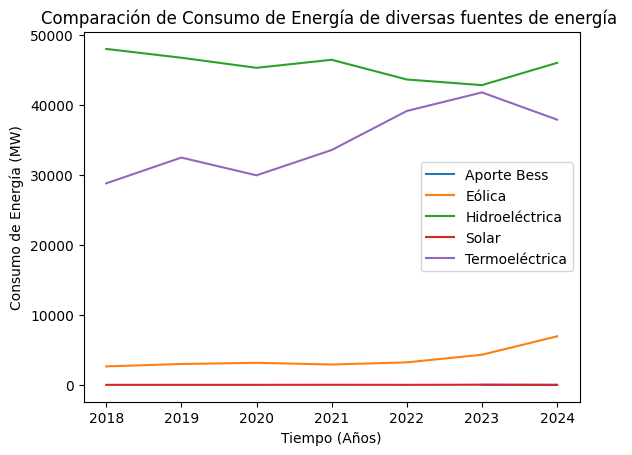

In [349]:
for electricity_type in df_grouped_by_type_and_year.loc[:,"Tipo de Generación"].unique():
    print(electricity_type)
    plt.plot(df_grouped_by_type_and_year[df_grouped_by_type_and_year["Tipo de Generación"]==electricity_type]["Año"], df_grouped_by_type_and_year[df_grouped_by_type_and_year["Tipo de Generación"]==electricity_type]["Consumo(MW)"], label = electricity_type)

plt.xlabel("Tiempo (Años)")
plt.ylabel("Consumo de Energía (MW)")
plt.legend()
plt.title('Comparación de Consumo de Energía de diversas fuentes de energía ')
plt.show()

### Summary of Insight Number 1
Answer to the question in **Insight Number 1**: As we can see in the previous line chart, the energy sources that consume the most energy are: 
* Hydroelectric
* Termoelectric

Once we have reduced our scope, we will now analyze these two energy sources in detail.

## TASK: Evaluating outliers for our top 2 

In [350]:
df_hydro = df[df["Tipo de Generación"]=="Hidroeléctrica"]
df_termo = df[df["Tipo de Generación"]=="Termoeléctrica"]

print(f"Hydroelectric data: \n\n{df_hydro.describe()}, \n\n")
print(f"Termoelectric data: \n\n{df_termo.describe()}, \n")

Hydroelectric data: 

       Consumo(MW)          Año
count    84.000000    84.000000
mean   3795.837568  2021.000000
std     646.568613     2.012012
min    2316.295270  2018.000000
25%    3198.187813  2019.000000
50%    3942.237210  2021.000000
75%    4394.551642  2023.000000
max    4745.408640  2024.000000, 


Termoelectric data: 

       Consumo(MW)          Año
count    84.000000    84.000000
mean   2898.615050  2021.000000
std     713.952072     2.012012
min     793.168490  2018.000000
25%    2333.264638  2019.000000
50%    2840.579265  2021.000000
75%    3315.536820  2023.000000
max    4569.869390  2024.000000, 



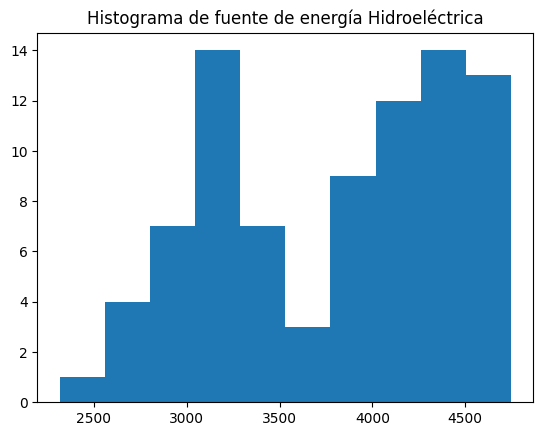

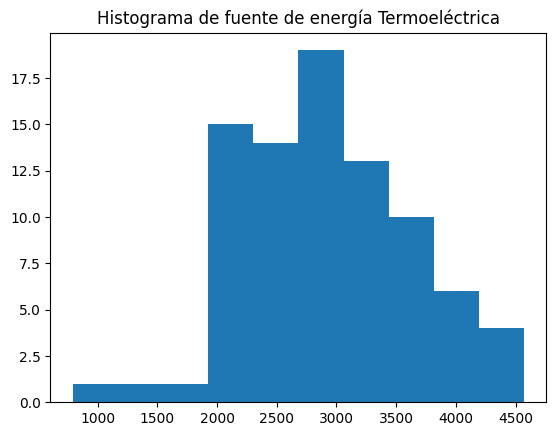

In [351]:
plt.hist(df_hydro["Consumo(MW)"])
plt.title("Histograma de fuente de energía Hidroeléctrica")
plt.show() 


plt.hist(df_termo["Consumo(MW)"])
plt.title("Histograma de fuente de energía Termoeléctrica")
plt.show() 


## Insigth Number 2
Now that we have our top 2, we will evaluate the outliers, we can ask the following questions:
* `For each energy type, in which year did we consume more and less energy?`

In [364]:
## For Hydroelectric
df_hydro_grouped_by_year = df[df["Tipo de Generación"]=="Hidroeléctrica"].groupby("Año")['Consumo(MW)'].sum().reset_index()
max_hydro_data = df_hydro_grouped_by_year.max().to_list() # Year, consume (MW)
min_hydro_data = df_hydro_grouped_by_year.min().to_list() # Year, consume (MW)

print(f"The maximum energy consumed for hydroelectric was in {max_hydro_data[0]:.0f}, consuming {max_hydro_data[1]:.0f} MW")
print(f"The minimum energy consumed for hydroelectric was in {min_hydro_data[0]:.0f}, consuming {min_hydro_data[1]:.0f} MW\n")

## For Termoelectric
df_termo_grouped_by_year = df[df["Tipo de Generación"]=="Termoeléctrica"].groupby("Año")['Consumo(MW)'].sum().reset_index()
max_termo_data = df_termo_grouped_by_year.max().to_list() # Year, consume (MW)
min_termo_data = df_termo_grouped_by_year.min().to_list() # Year, consume (MW)

print(f"The maximum energy consumed for termolectric was in {max_termo_data[0]:.0f}, consuming {max_termo_data[1]:.0f} MW")
print(f"The minimum energy consumed for termolectric was in {min_termo_data[0]:.0f}, consuming {min_termo_data[1]:.0f} MW")



The maximum energy consumed for hydroelectric was in 2024, consuming 47984 MW
The minimum energy consumed for hydroelectric was in 2018, consuming 42813 MW

The maximum energy consumed for termolectric was in 2024, consuming 41772 MW
The minimum energy consumed for termolectric was in 2018, consuming 28779 MW


### Summary of Insight Number 2
Answering to the question formulated in **Insight Number 2**.
* The results indicate that the maximum electricity consumption for both termoelectric and hydroelectric was in 2024, and the minimum in 2018. 


## Insight 3: Evaluating maximum and minimun value for hydroelectric and termoelectric based on seasons

We saw the maximum energy for both hydroelectric and Termoelectric. The energy consumption may vary depending on the season, sometimes it increases or decreases, so that will our next analysis.
* `For each energy type, In which seasons we have consumed more energy?`

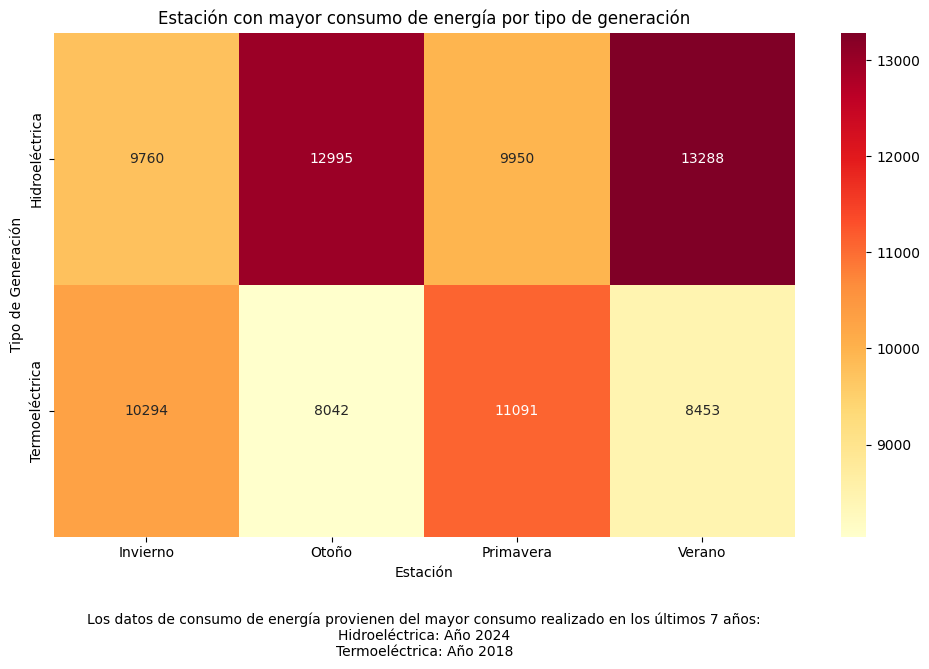

In [363]:
## Maximum consume
df_max_hydro = df[(df["Tipo de Generación"]=="Hidroeléctrica") & (df["Año"]==2024)]
df_max_termo = df[(df["Tipo de Generación"]=="Termoeléctrica") & (df["Año"]==2024)]
df_max_consume = pd.concat([df_max_hydro, df_max_termo], axis=0)              
heatmap_consumption_by_season(df_max_consume, "Estación con mayor consumo de energía por tipo de generación") 
                    

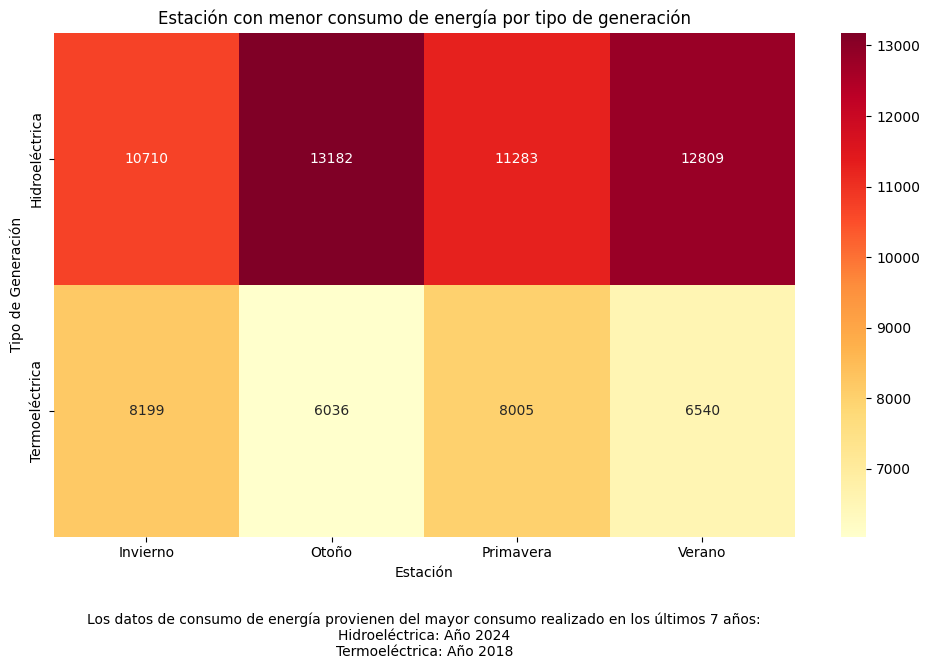

In [ ]:
## Minimum consume
df_min_hydro = df[(df["Tipo de Generación"]=="Hidroeléctrica") & (df["Año"]==2018)]
df_min_termo = df[(df["Tipo de Generación"]=="Termoeléctrica") & (df["Año"]==2018)]
df_min_consume = pd.concat([df_min_hydro, df_min_termo], axis=0)              
heatmap_consumption_by_season(df_min_consume, "Estación con menor consumo de energía por tipo de generación") 
                    


Actually if we evaluate thhe energy consumed of each energy resource type by season, we can see this behavior is repeated.

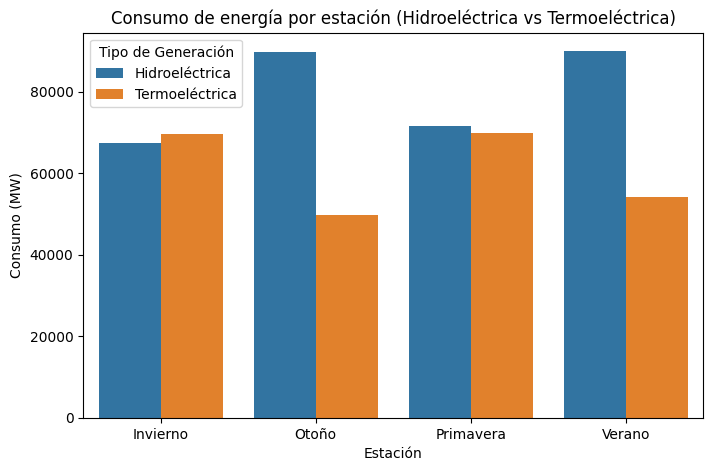

In [372]:
pivot = (
    df[df["Tipo de Generación"].isin(["Hidroeléctrica", "Termoeléctrica"])]
    .groupby(["Season", "Tipo de Generación"])["Consumo(MW)"]
    .sum()
    .reset_index()
)

# Gráfico de barras
plt.figure(figsize=(8,5))
sns.barplot(data=pivot, x="Season", y="Consumo(MW)", hue="Tipo de Generación")

plt.title("Consumo de energía por estación (Hidroeléctrica vs Termoeléctrica)")
plt.ylabel("Consumo (MW)")
plt.xlabel("Estación")
plt.legend(title="Tipo de Generación")
plt.show()



### Summary of Insight Number 3
Answering to the question formulated in **Insight Number 3**.
* For hydroelectric seasons Autumn and Summer are the ones when more energy was consumed
* For termoelectric seasons Winter and Spring are the ones when more energy was consumed




# Summary of the analysis 

In recent years, thermoelectric generation in Peru has shown a consistent increase, while hydroelectric production has remained relatively stable without abrupt changes. Wind and solar energy have also maintained low and steady levels of contribution. Ideally, a greater share of renewable sources should be incorporated into the national energy mix. However, new challenges come with it:
* Renewable source is not always feasible due to seasonal factors, such as rainfall variability, which directly affects hydroelectric output. 
* In addition, although many renewable projects already have concessions approved, regulatory barriers and legal obstacles have delayed their development.
* Another challenge is the inherent intermittency of renewable resources: solar and wind cannot yet guarantee a fully reliable supply, especially during unfavorable climatic conditions. Consequently, thermoelectric plants continue to play a critical role as a backup source, despite their high environmental cost in terms of greenhouse gas emissions and local pollution.

* The record-high energy consumption observed in 2024 can therefore be attributed not only to growing demand but also to structural factors: dependence on fossil fuels to ensure grid reliability, the slow expansion of renewable projects, regulatory and technical constraints, and possible hydrological conditions. While hydroelectric energy maintains a strong presence, the increasing reliance on thermoelectric generation highlights the urgent need to accelerate the energy transition in order to reduce environmental impacts and improve sustainability.
